In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *
import numpy as np

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

print(X.shape)
X.head()


(1460, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [15]:
most_missing = get_missing_values_info(data)
most_missing

,Total,%
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


In [16]:
data=data.drop(columns=['PoolQC', 'MiscFeature','Alley', 'Fence'], axis=1)

In [17]:
#magical seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=98987)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

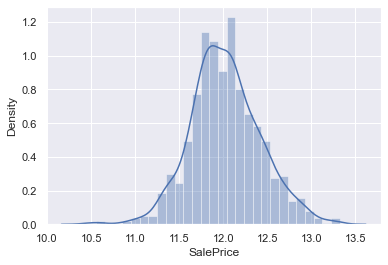

In [18]:
sns.distplot(y_train)

<AxesSubplot:>

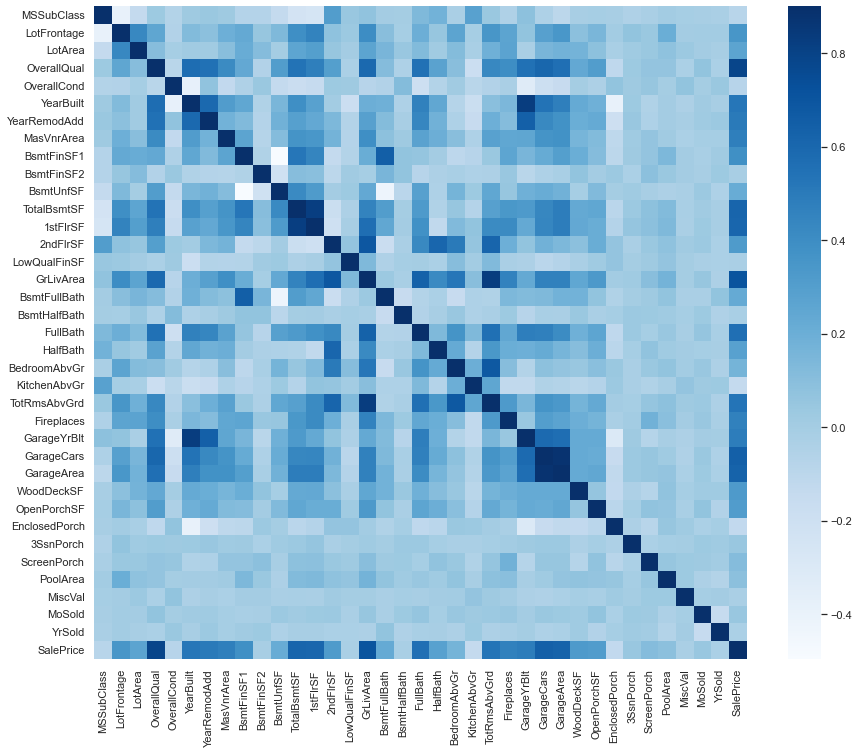

In [19]:
corr = data.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

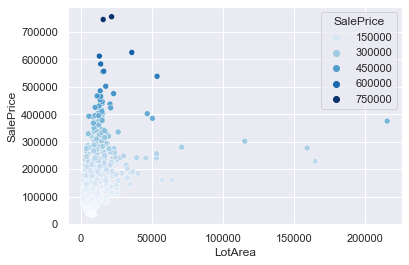

In [20]:
sns.scatterplot(x='LotArea', y='SalePrice', hue='SalePrice', palette='Blues', data=data)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

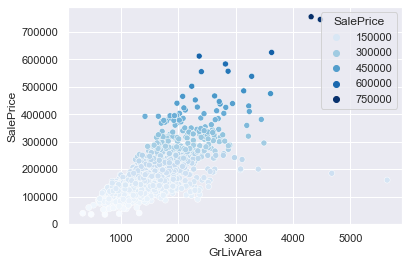

In [21]:
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='SalePrice', palette='Blues', data=data)

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

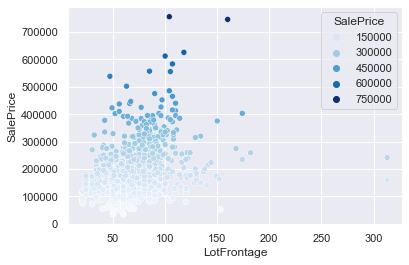

In [22]:
sns.scatterplot(x='LotFrontage', y='SalePrice', hue='SalePrice', palette='Blues', data=data)

<AxesSubplot:xlabel='ScreenPorch', ylabel='Count'>

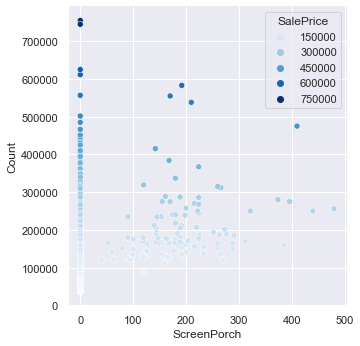

In [23]:
sns.displot(data["ScreenPorch"])
sns.scatterplot(x='ScreenPorch', y='SalePrice', hue='SalePrice', palette='Blues', data=data)

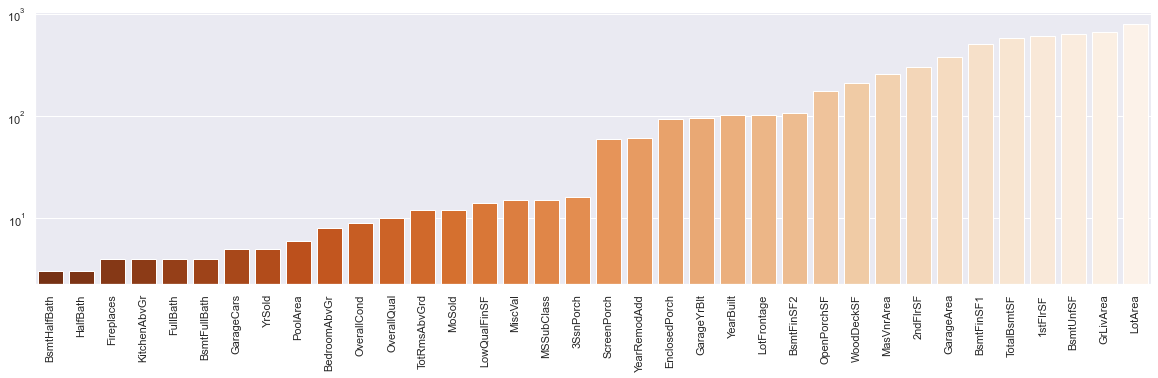

In [24]:
num_candidates = list(X_train.dtypes[X_train.dtypes!="object"].index.values)

unique_counts = X_train.loc[:, num_candidates].nunique().sort_values()

plt.figure(figsize=(20,5))
sns.barplot(unique_counts.index, unique_counts.values, palette="Oranges_r")
plt.xticks(rotation=90)
plt.yscale("log")

36


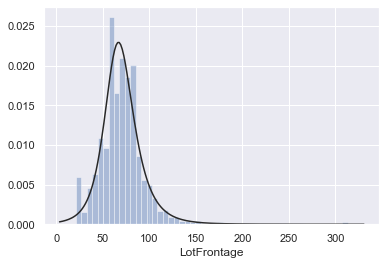

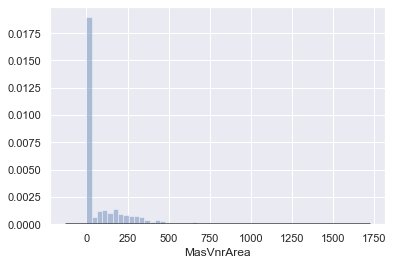

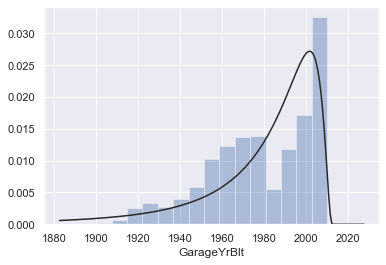

In [41]:
import scipy.stats as stats
from scipy.stats import skew

print(len(num_candidates))
#_, axes = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))

for col in num_candidates:
    total=data[col].isnull().sum()
    if total > 0:
        plt.figure()
        sns.distplot(data[data[col].notnull()][col], kde=False, fit=stats.johnsonsu)

plt.show()

In [26]:
X_train.loc[:,"Utilities"].value_counts()

AllPub    1022
Name: Utilities, dtype: int64

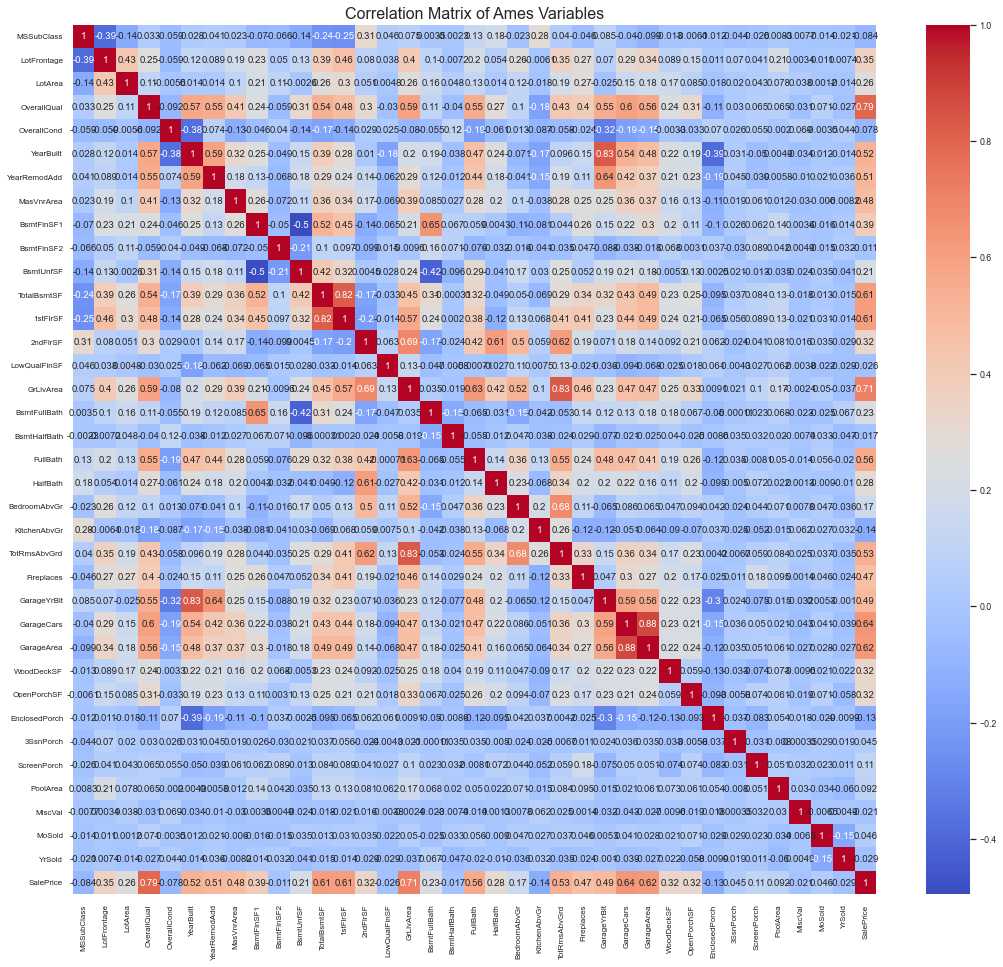

In [27]:
fig, ax = plt.subplots(figsize=(18, 16))

sns.set(font_scale=0.8)
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Ames Variables", fontsize=16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=8)
plt.show()

In [40]:
numeric_data = list(data.dtypes[data.dtypes!="object"].index.values)

most_missing = get_missing_values_info(data[numeric_data])
most_missing

,Total,%
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
MasVnrArea,8,0.547945


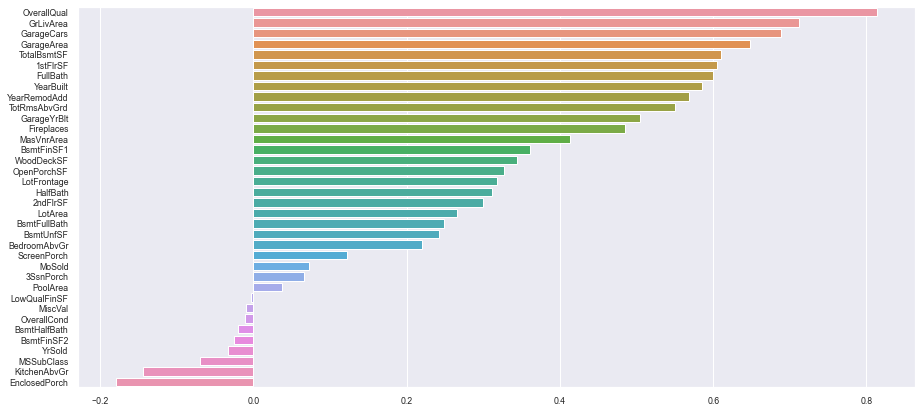

In [28]:
numeric_data = X_train.select_dtypes([np.number])

X_train_filled, data_mean = fill_nan(X_train)
X_test_filled = X_test.fillna(data_mean)

numeric_data_mean = numeric_data.mean()

numeric_features = numeric_data.columns

X_train_filled = X_train.fillna(numeric_data_mean)
X_test_filled = X_test.fillna(numeric_data_mean)

correlations = X_train_filled[numeric_features].corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 7)

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

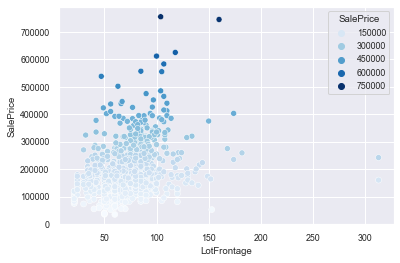

In [30]:
sns.scatterplot(x='LotFrontage', y='SalePrice', hue='SalePrice', palette='Blues', data=data)

<h2>Train on numeric data only</h2>

In [31]:
enc = one_hot_encode(X_train_filled)

In [32]:
enc.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
597,120,53.000000,3922,7,5,2006,2007,72.0,0,0,...,0,1,0,0,0,0,0,0,0,1
239,50,52.000000,8741,6,4,1945,1950,0.0,94,0,...,0,0,0,1,0,0,0,0,1,0
212,60,72.000000,8640,7,5,2009,2009,0.0,822,0,...,0,1,0,0,0,0,0,0,0,1
1155,20,90.000000,10768,5,8,1976,2004,0.0,1157,0,...,0,0,0,1,0,0,0,0,1,0
384,60,70.841121,53107,6,5,1992,1992,0.0,985,0,...,0,0,0,1,0,0,0,0,1,0


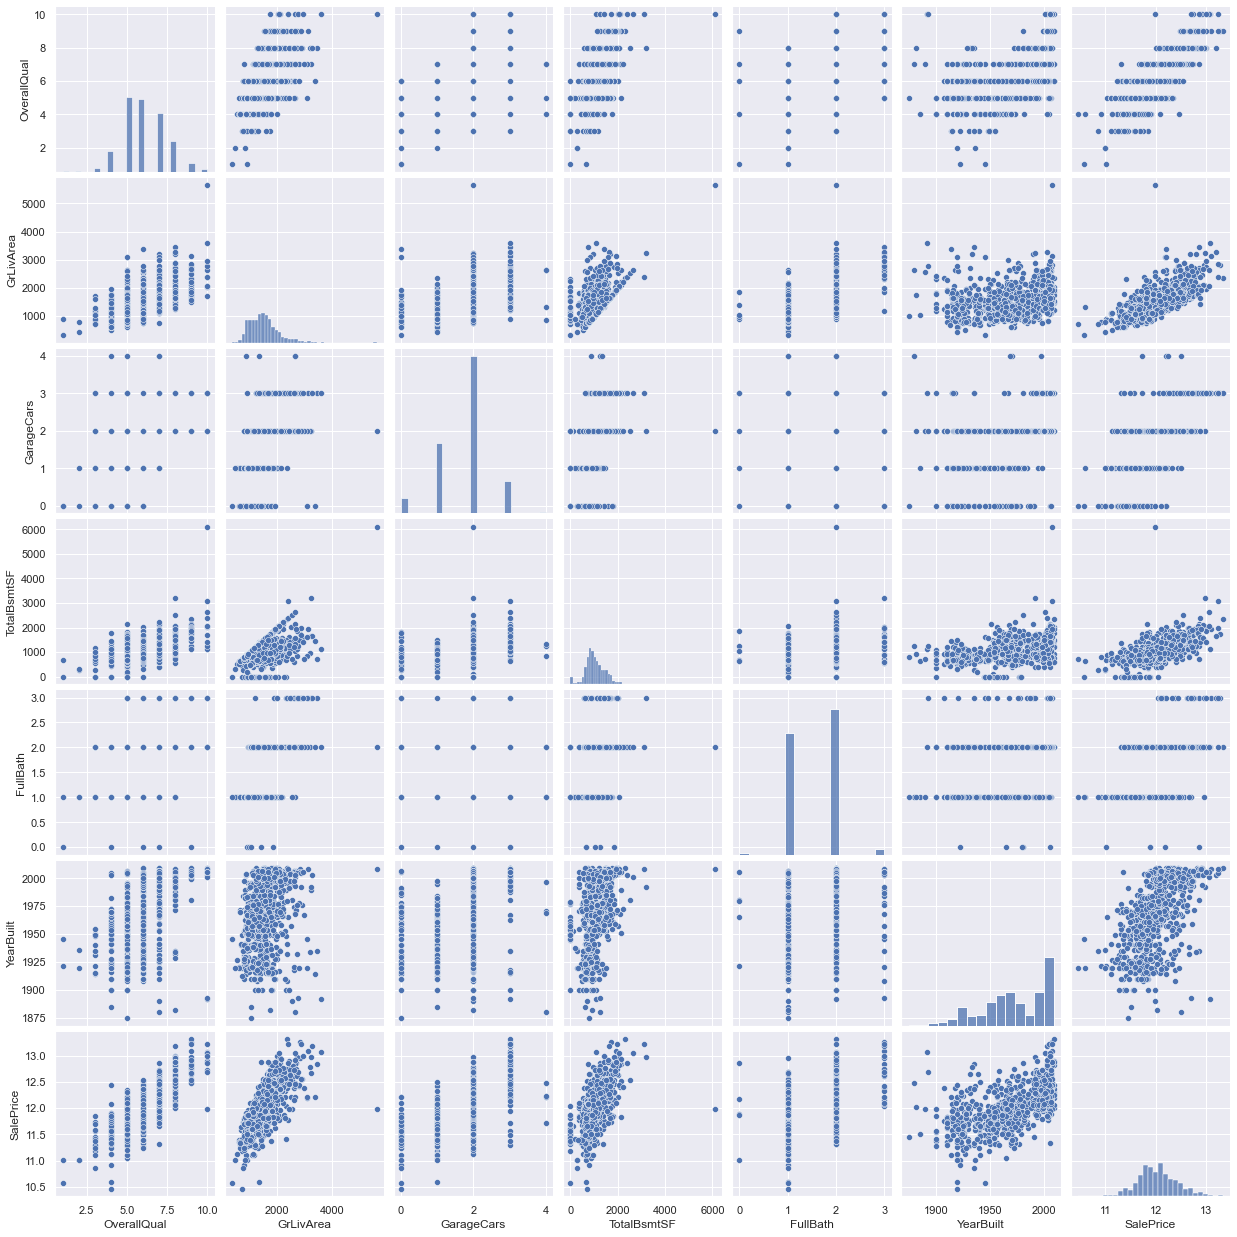

In [33]:
sns.set()
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(pd.concat([X_train_filled[cols], y_train], axis=1), size = 2.5)
plt.show()

In [34]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(enc)

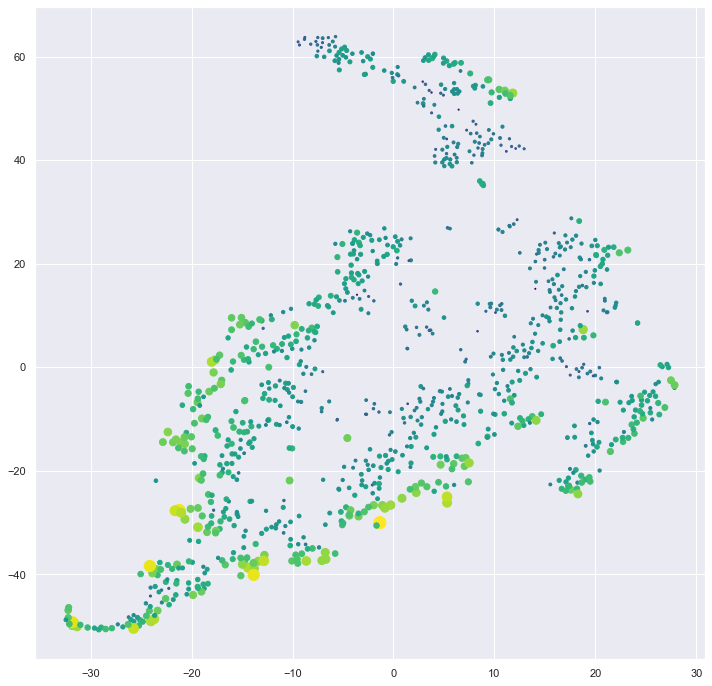

In [35]:
norm = plt.Normalize()

colors = plt.cm.viridis(norm(y_train))

min_y = y_train.min()
max_y = y_train.max()

plot = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s = np.exp(5*(y_train - min_y)/(max_y - min_y)) ** 1, c = colors)
plot.figure.set_size_inches(12, 12)

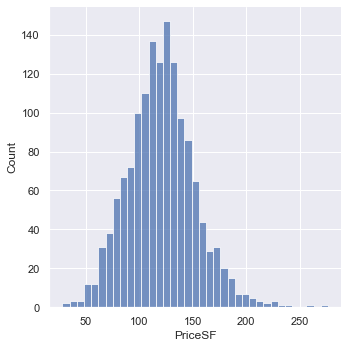

In [36]:
data['PriceSF'] = np.expm1(y) / data.GrLivArea
sns.displot(data['PriceSF'])

<AxesSubplot:xlabel='MoSold', ylabel='PriceSF'>

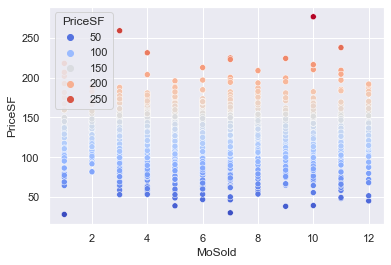

In [37]:
sns.scatterplot(x='MoSold', y='PriceSF', hue='PriceSF', palette='coolwarm', data=data)

In [38]:
print(data.SalePrice[(data.SaleCondition == 'Family')].count())

20
